# OFFICAL data used the 23 July 2021 version of hstscan

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

import astropy.constants as cs
import os

import astropy.io.fits as pyfits

import hstscan.pipeline as pipe
import hstscan.reduction as r
import hstscan.data as data
from hstscan.data import view_frame_image as view
import tqdm
import glob
import csv

# Setup for light-curve reduction

### 1) Download data
https://archive.stsci.edu/hst/search.php

\_ima files for all data

\_drz and \_flt files for the direct images (taken with Filters instead of Grism)

Get HST ephemeris data at https://ssd.jpl.nasa.gov/horizons.cgi?s_tset=1#top

In [2]:
# data_dir: directory where the _ima files are stored
Dir = '/Users/bob/Documents/PhD/KELT-9b/'
data_dir = Dir + 'HSTdata/'
output_dir = Dir + 'output/'

conf_file_red = Dir + 'transmission_reduction.conf'
conf_file_ext = Dir + 'transmission_extraction.conf'

#Define a table of custom knots. A row for each subexposure. 
#If you haven't created this yet, please run the remainder of this code to find out the best knots.
#Then create your own table with *interior* knots in ascending order
custom_knots = []
import csv
custom_knots = []
if os.path.isfile(Dir + 'custom_knots.csv'):
    with open(Dir + 'custom_knots.csv', 'rb') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for row in spamreader:
            row = np.array(row)
            custom_knots.append(row[row != ''].astype(float))
    noknots=False
else:
    noknots=True

### 2) Produce visit information lists

At this point it makes sense to re-name the visit files to more appropriate names, e.g. visit_26.lis -> transit.lis

### 3) Define a list of reference files

These reference files are used to calculate the absolute wavelength solution. They are typically the first grism exposures of each visit. Each visit should have at least one reference exposure.

In [11]:
ref_Images = ['ie3zh1uuq_ima.fits']
#ref_Images = ['ie3zh1tfq_ima.fits']

### 4) Fit direct image positions to produce position catalogues

Writing to: /Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1utq_flt_1.cat
/Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1utq_flt.fits
Shape (512, 512)


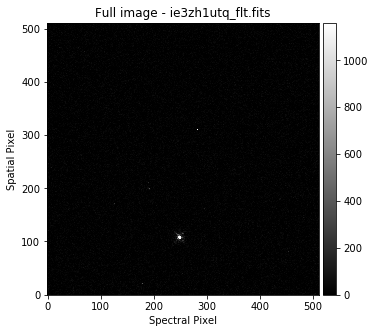

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude  1.475e+05        0      inf    101.5     True     None     None
x_mean        249.6        0      512 0.0003152     True     None     None
x_stddev     0.6427        0      inf 0.0005514     True     None     None
y_mean        108.1        0      512 0.0004449     True     None     None
y_stddev     0.5461        0      inf 0.0002757     True     None     None


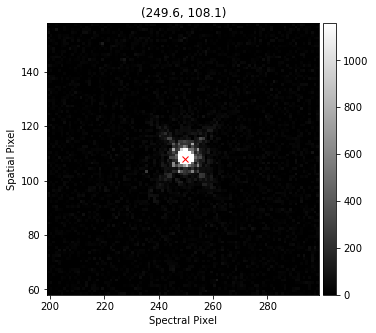

Writing to: /Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1x1q_flt_1.cat
/Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1x1q_flt.fits
Shape (512, 512)


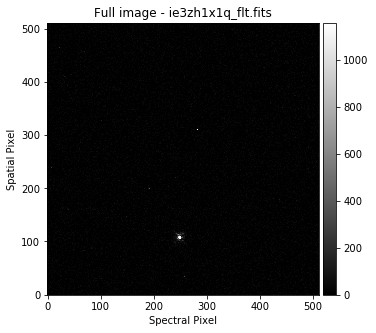

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude  1.473e+05        0      inf    84.33     True     None     None
x_mean        249.5        0      512 0.0002729     True     None     None
x_stddev     0.6493        0      inf 0.0004756     True     None     None
y_mean          108        0      512 0.0003837     True     None     None
y_stddev     0.5446        0      inf 0.000216     True     None     None


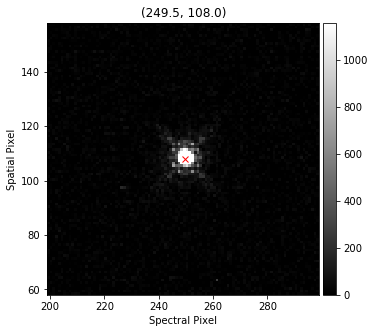

Writing to: /Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1tdq_flt_1.cat
/Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1tdq_flt.fits
Shape (512, 512)


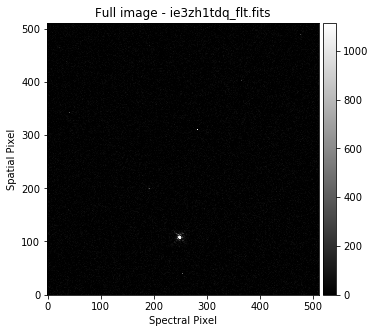

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude  1.455e+05        0      inf    85.39     True     None     None
x_mean        249.5        0      512 0.0002713     True     None     None
x_stddev     0.6498        0      inf 0.000484     True     None     None
y_mean        108.1        0      512 0.0003836     True     None     None
y_stddev     0.5487        0      inf 0.0002268     True     None     None


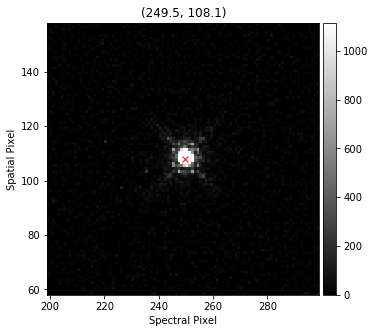

Writing to: /Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1wbq_flt_1.cat
/Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1wbq_flt.fits
Shape (512, 512)


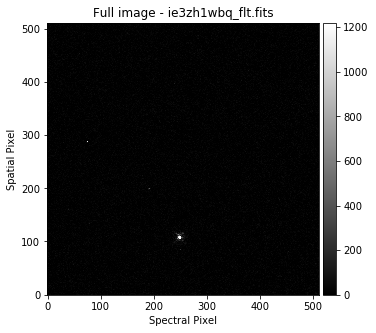

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude  1.499e+05        0      inf     89.8     True     None     None
x_mean        249.6        0      512 0.0002813     True     None     None
x_stddev     0.6329        0      inf 0.0004786     True     None     None
y_mean          108        0      512 0.0003915     True     None     None
y_stddev     0.5433        0      inf 0.0002253     True     None     None


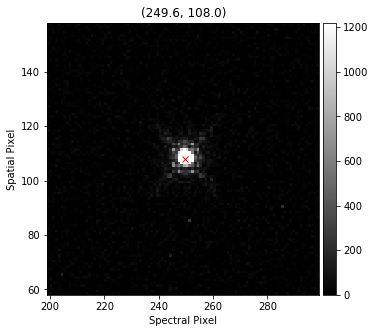

Writing to: /Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1u2q_flt_1.cat
/Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1u2q_flt.fits
Shape (512, 512)


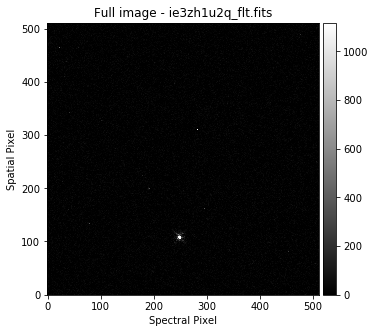

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude  1.449e+05        0      inf    102.7     True     None     None
x_mean        249.5        0      512 0.0003233     True     None     None
x_stddev     0.6485        0      inf 0.0005701     True     None     None
y_mean        108.1        0      512 0.000457     True     None     None
y_stddev     0.5479        0      inf 0.0002914     True     None     None


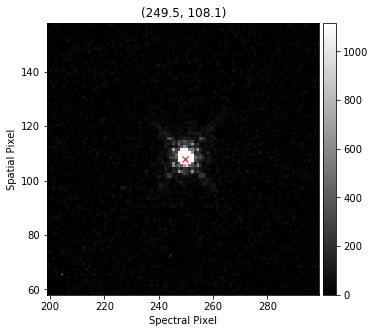

Writing to: /Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1vkq_flt_1.cat
/Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1vkq_flt.fits
Shape (512, 512)


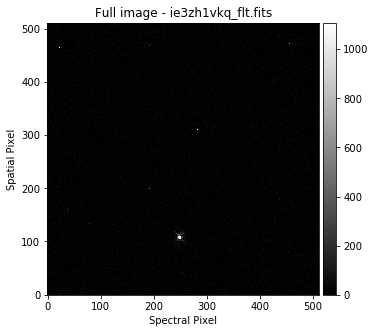

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude  1.459e+05        0      inf    85.29     True     None     None
x_mean        249.5        0      512 0.0002695     True     None     None
x_stddev      0.651        0      inf 0.0004809     True     None     None
y_mean        108.1        0      512 0.0003827     True     None     None
y_stddev     0.5472        0      inf 0.0002292     True     None     None


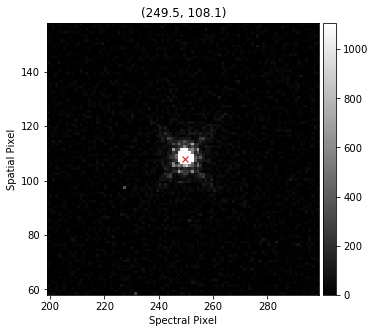

In [12]:
# gridsize: coarseness of initial search for source
# nstars: number of stars for which positions should be measured (in order of brightness)
# use_ima: use _ima files instead of _flt in case of problems
reload(pipe)
pipe.create_orbit_cats_gauss(data_dir=data_dir, conf_file=conf_file_red, gridsize=50, use_ima=False, nstars=1)

Now have everything you need to reduce an exposure and produce spectra

# Config file parameters

## Red

### Parameters to define yourself
 - source_dir
 - save_dir
 - scan_rate
 - bg_x,y,w,h
 - flat_file_g141
 - conf_file_g141
 - ref_exp
 - stellar_spectrum (PHOENIX model. TBF @ http://phoenix.astro.physik.uni-goettingen.de/?page_id=15) from https://arxiv.org/pdf/1303.5632.pdf
     You could also use a .txt file with one column of wavelengths in Angstrom and one of Flux in erg/s/cm^2/A. This file should have a one-line-header. This is useful if you want to use an ATLAS spectrum.
 - stellar_wavelengths (PHOENIX model wavelength definition)
 
### Leave
These you are unlikely to want to change, although their effects are important
 - scanned = True
 - units = True
 - read_noise = 20
 - skip_start = 1
 - skip_end = 0
 - bg = True
 - bg_area = True
 - cr_local = True
 - dispersion = True
 - flat_field = True
 - ff_min = 0.5
 - contam_thresh = 0.01
 - nysig = 5
 - disp_coef = 'wilkins'
 - stel_spec_gauss_kern_sig = 1
 - calc_abs_xshift = True.   #Whether to calculate the wavelength solution from the grism transmission fct.
 - tai_utc_file
 
### Cosmic Rays
You may want to experiment with cosmic ray removal parameters, can turn off cosmic ray removal for a first run
 - cr_tol = 15 (in sigmas) (try to lower without removing spectrum)
 - cr_x,y (consider tweaking if CR removal too agressive/weak)
 - cr_thresh = 50 (can raise)

### Data quality flags
Lookup flags in data handbook. 4: Bad detector pixel, 32: IR unstable pixel.

Leave as is unless there are problems.
 - dq_flags = [4,32]
 - dq_replace = None
 - dq_mean_width = 1
 
### Wavelength Solution
For now, disable the Tsiaras wavelength solution and use the simple interpolation.
May want to tweak drift_width and rowtol, parameters for smoothing the drift within an exposure.

E.g. define
 - exp_shift = False
 - tsiaras = False
 - exp_drift = True
 - drift_width = 4
 - drift_rowtol = 1.1


### Plots
Leave on while still tweaking
 - debug = True
 - pdf = True
 - logger = True
 - bg_plot = True
 - cr_plot = True
 
### Tweak to position extraction box
Depending on the observations, need to account/remove different effects to center the spectrum in the extraction box. Have not figured out a universal solution.

 - remove_scan
 - postarg_yguess
 - default_scan
 
 
### Ignore
These are either no longer used, in development, or were for specific data sets/modes.
 - system
 - nlincorr
 - psf_h (these are for bg removal with masks)
 - mask_h
 - psf_w
 - n_masks
 - neg_masks
 - cr_replace
 - cr_master
 - cr_mname
 - ref_exp
 - ref_wv0
 - ref_wv1
 - pre_shift_ff
 - peak
 - x_shift_ext
 - grid_y
 - grid_lam
 - two_scans 
 - interp_kind
 - object_ind

## Ext

### Parameters to define yourself
 - save_dir
 - box_h (ensure large enough to capture whole spectrum)
 - ref_exp
 
### Plots
- debug = True
- logger = True
- pdf = True
- oe_debug = False (its very slow, turn on only if focusing on optimal extraction)

### Leave
 - save_extension = '_spec.txt'
 - calc_var = True
 - extraction_box = True
 - shift_spectra = True
 - shift_wv0 = 1.14
 - shift_wv1 = 1.6
 - peak = False
 - opt_ext = True
 - exp_shift = True
 
### Optimal Extraction

#### Tweak
- fit_tol
- order
- step (only works if func_type is not spline, custom_spline or split_spline and method is lsq
- k_col/row

#### Leave
- s = 0
- v_0 = 400
- q = 1
- s_clip = None
- s_cosmic = None
- func_type = 'spline'
- method = 'lsq'
- remove_bg = True
- object_ind = 0
- fit_dq = False
 
### Ignore
- save_sub
- mask_neg
- ignore_blobx
- blob_thresh
- skip_fit
- top_half

# Run data reduction on one exposure

Check 

 - Do the subexposures agree, smoothly across the whole wavelength range?
 
 - How many optimal extraction fits fail near the peak of the spectrum?
 
 - Check the fits, are they overfitting or underfitting clearly? Safer to overfit.

In [13]:
#Define the center pixel of each subexposure in y-direction. You can also run with the custom_knots=None argument to find out what these should be.
ypix_F = [417, 336, 254, 170]
ypix_R = [161, 244, 327, 410]
#ypix_F = np.array([417, 336, 254, 170])-20
#ypix_R = np.array([161, 244, 327, 410])-20

########################################
############Started Reduction##########
########################################
Data reduction pipeline performed on exposure /Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1uuq_ima.fits
For configuration, see pipeline conf file: /Users/bob/Documents/PhD/KELT-9b/transmission_reduction.conf


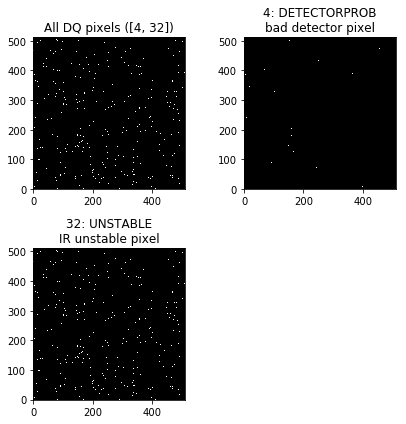

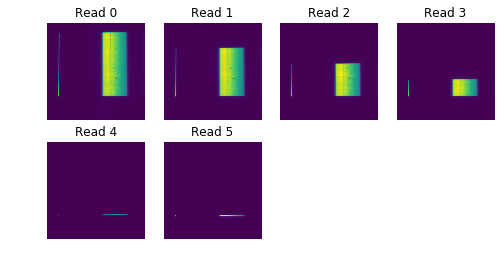

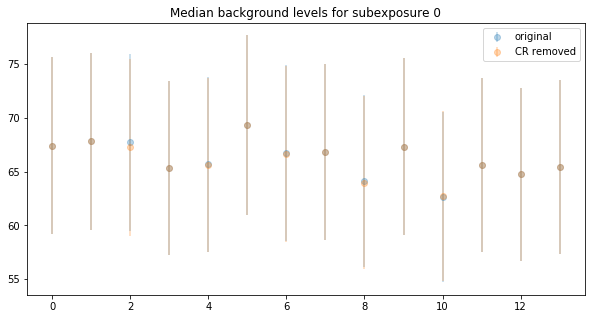

Large background of 66.2362670898 electrons per pixel found in subexposure 0


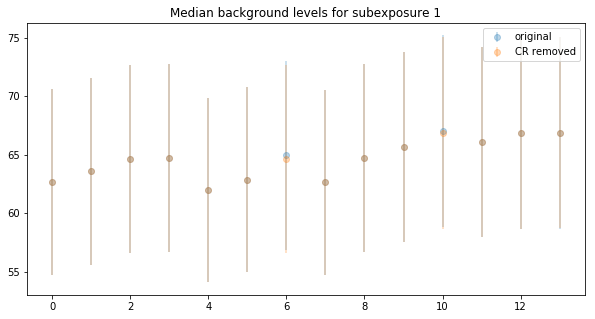

Large background of 64.6741943359 electrons per pixel found in subexposure 1


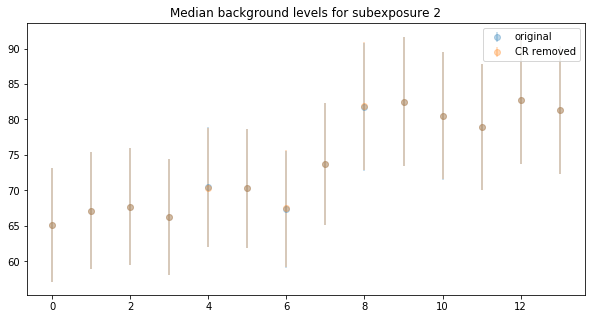

Large background of 74.1387481689 electrons per pixel found in subexposure 2


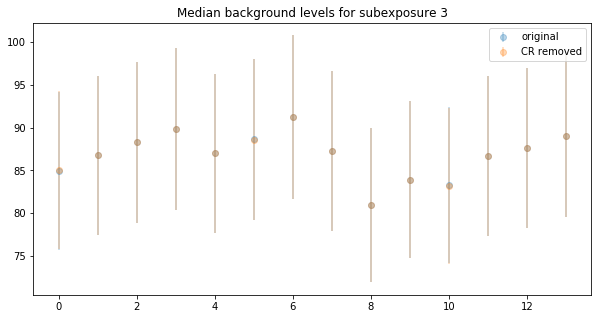

Large background of 86.6062469482 electrons per pixel found in subexposure 3


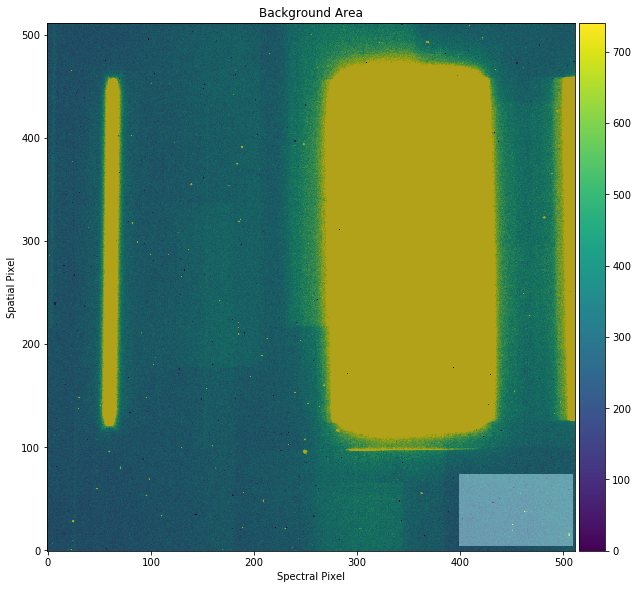

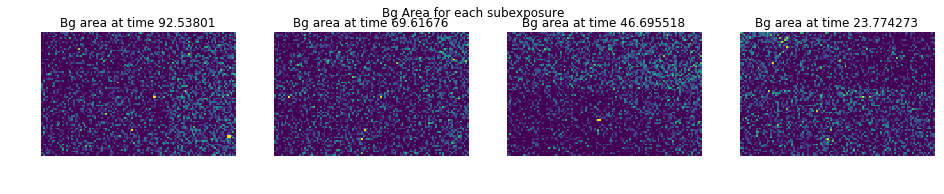

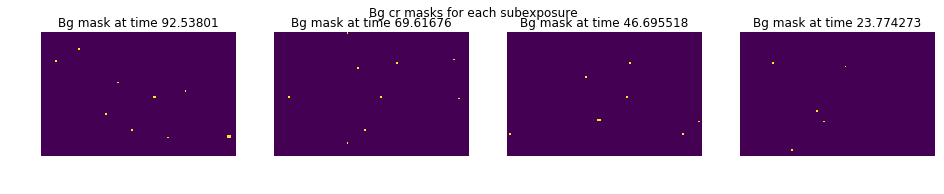

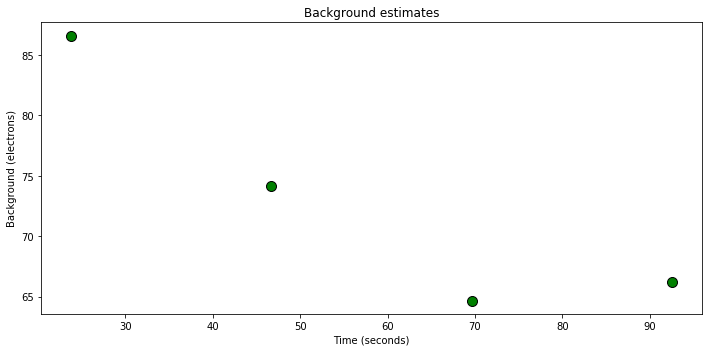

Forward scan
Catalogue used: /Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1tdq_flt_1.cat
Direct Image name: ie3zh1tdq
catalogue /Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1tdq_flt_1.cat
Catalogue file: ie3zh1tdq_flt.fits
########################
Direct image location of (249.526744058,108.06271209)
FWHM of this subexposure is  81.06801257074216


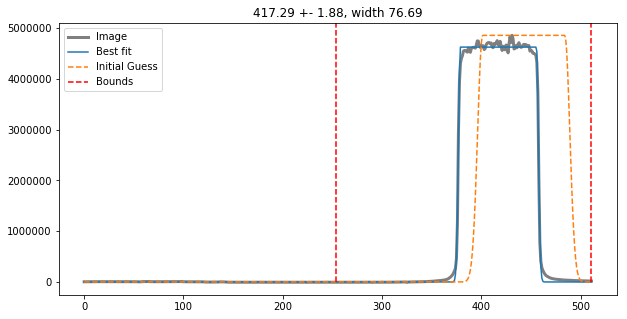

using a PHOENIX stellar model
amplitude and displacement on first order: -14.557916656910772 -2.1957350695205218


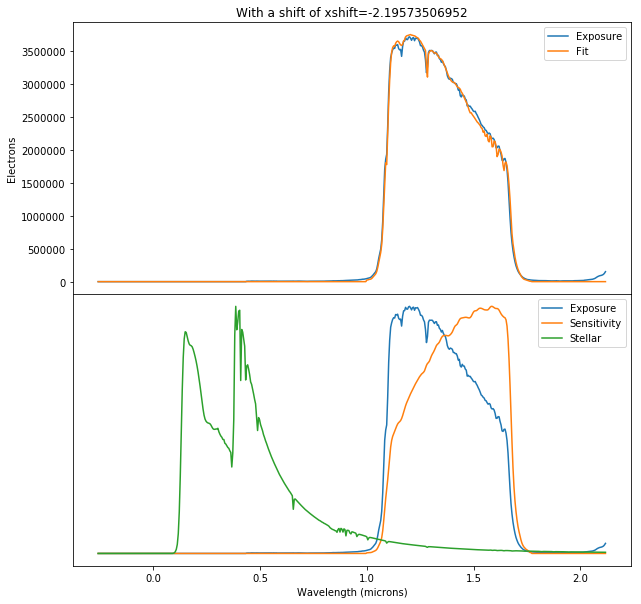

Applied an xshift of -2.19573506952 pix from a comparison to a stellar spectrum
Initial xpix is 247 and shift_in_x: -2.19573506952
-30 1
FWHM of this subexposure is  81.06800419769957


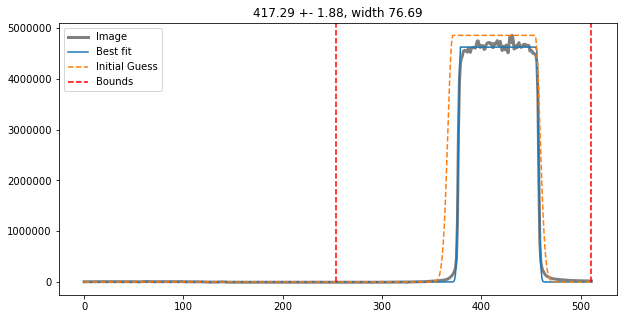

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]
-30 1
FWHM of this subexposure is  81.40968158795084


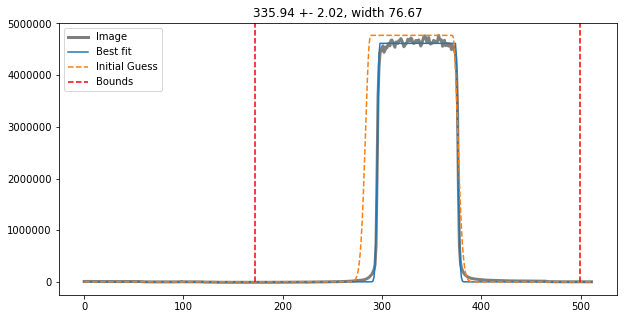

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]
-30 1
FWHM of this subexposure is  82.80670986608399


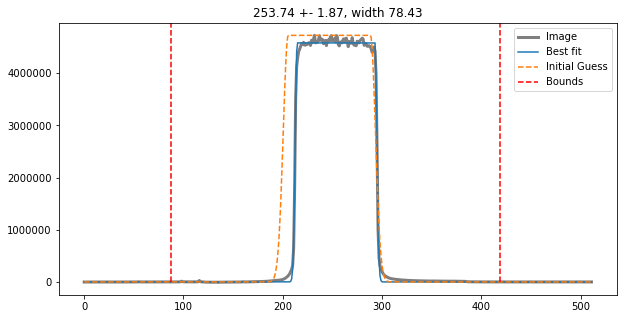

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]
-30 1
FWHM of this subexposure is  84.21699762316254


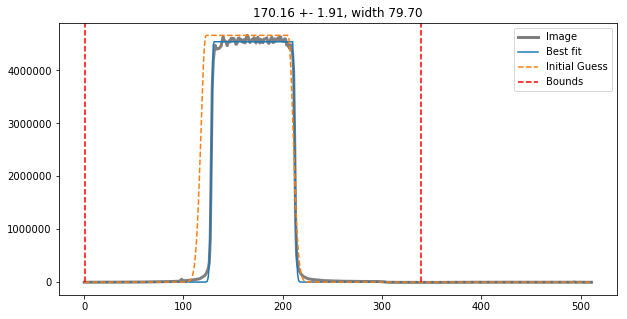

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]
The final xpix is 247
-30 1
FWHM of this subexposure is  81.06800419769957


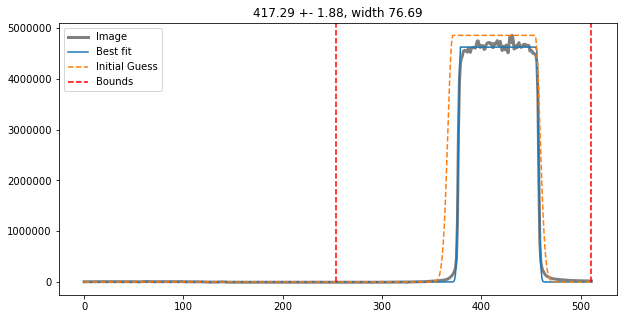

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]
-30 1
FWHM of this subexposure is  81.40968158795084


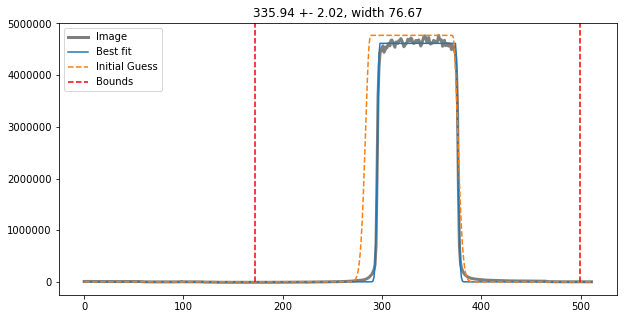

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]
-30 1
FWHM of this subexposure is  82.80670986608399


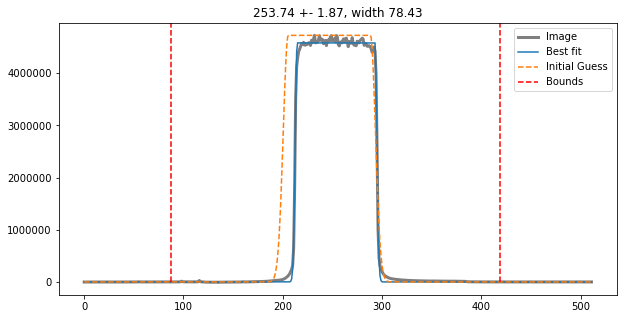

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]
-30 1
FWHM of this subexposure is  84.21699762316254


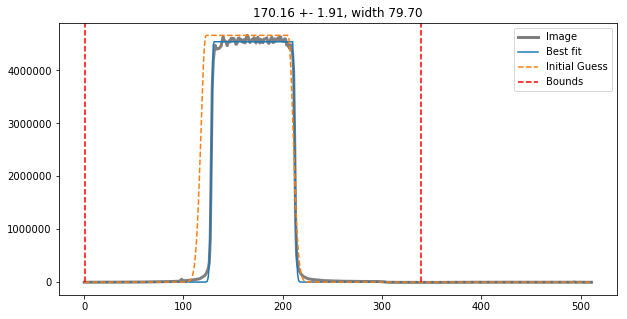

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]


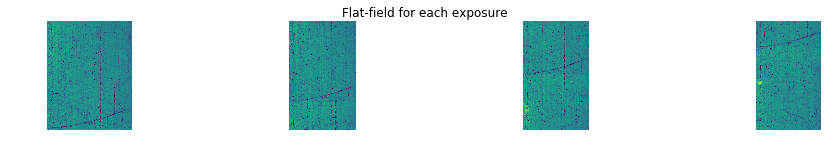

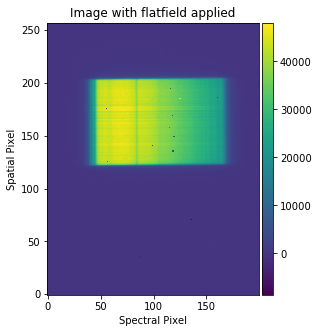

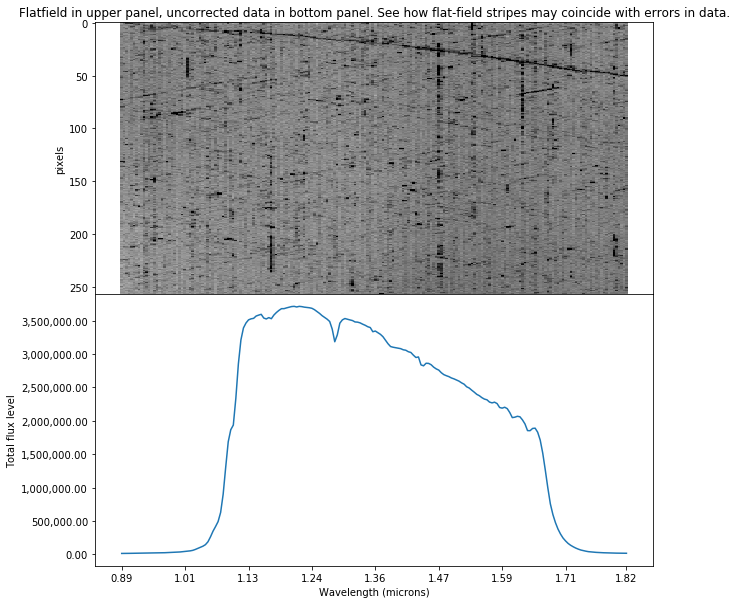

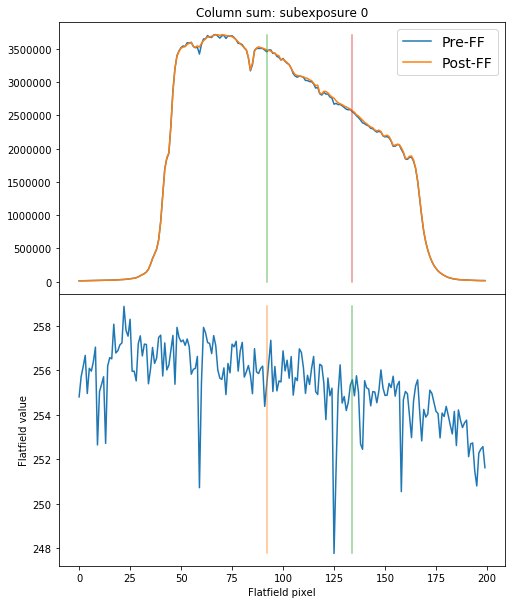

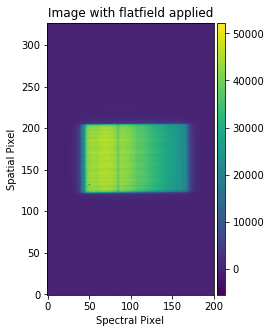

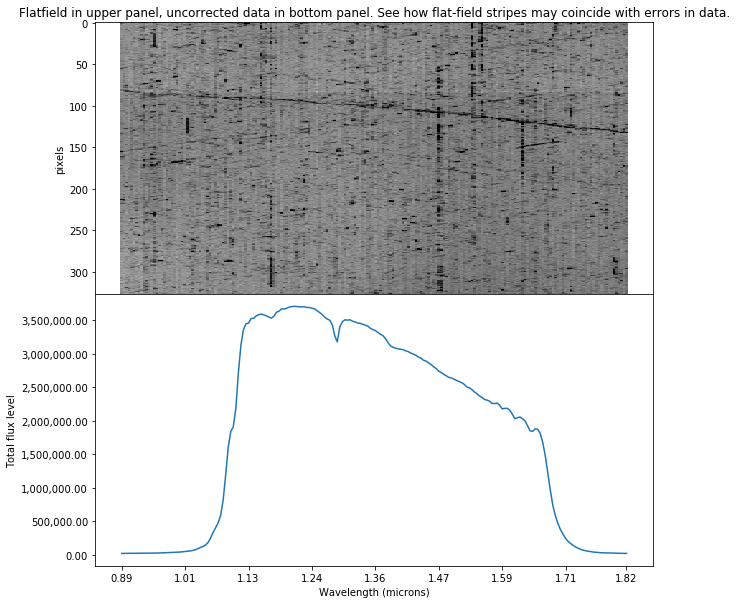

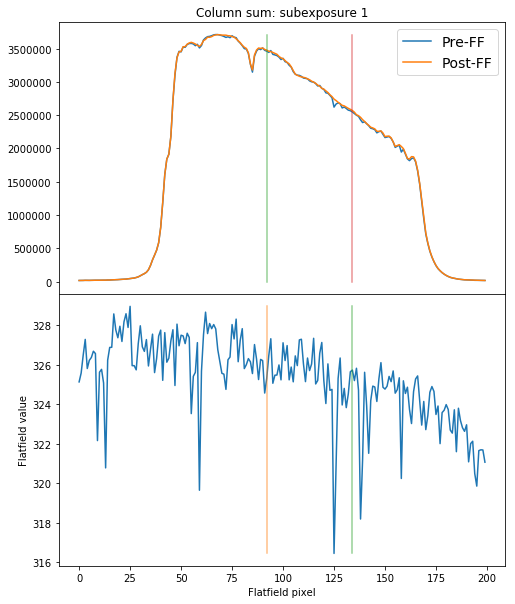

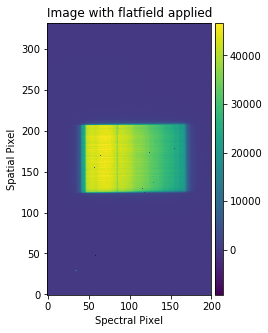

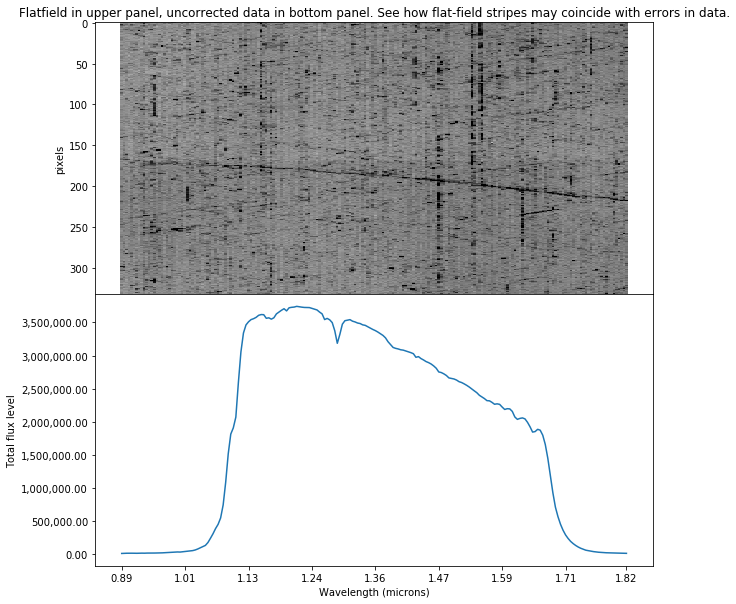

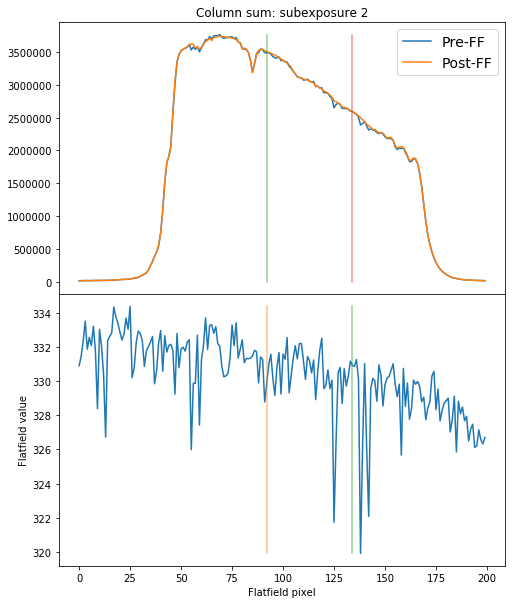

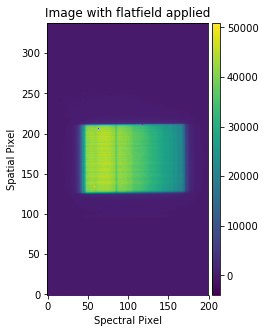

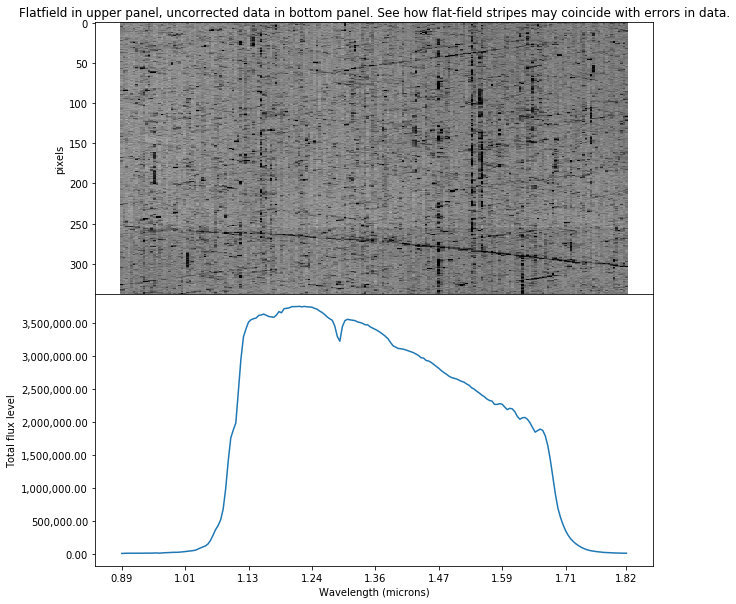

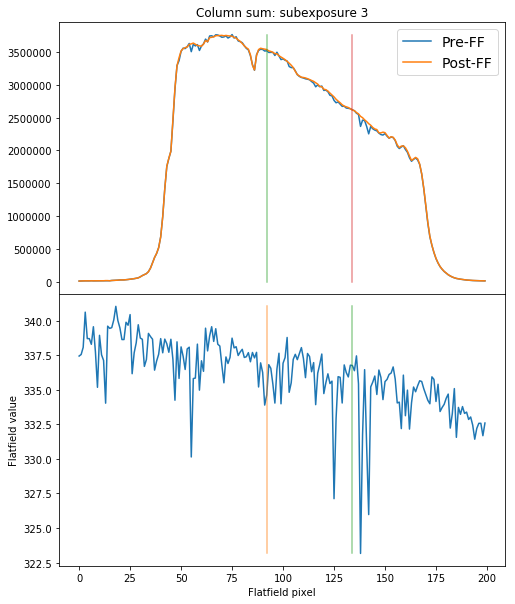

/Users/bob/opt/anaconda3/envs/hstscan/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


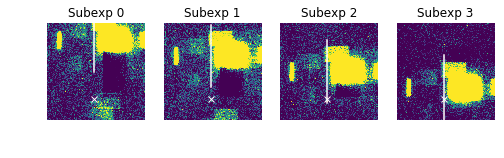

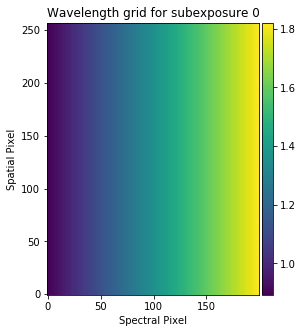

nr_CRs, Lows 226 16
nr_CRs, Lows 215 12
nr_CRs, Lows 228 10
nr_CRs, Lows 244 7


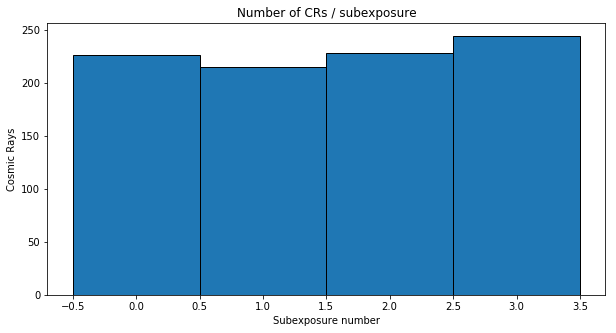

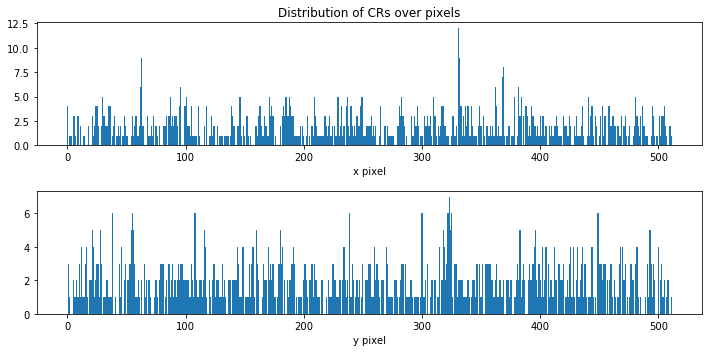

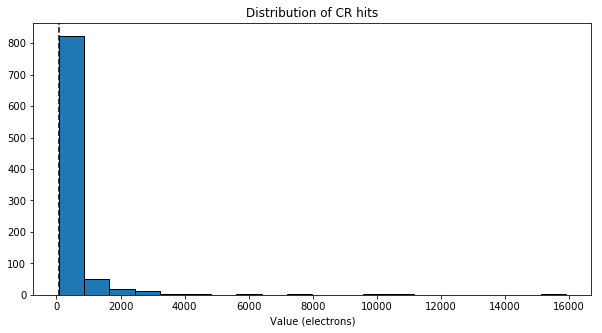

This should have a median energy of 1000 electrons
Nr. of DQs, CRs and CRs minus DQs 12252, 913 and 903
Percentage of pixels affected by CRs:0.344467163086 %, which should be ~0.359870038889% if there is no South Atlantic anomaly.


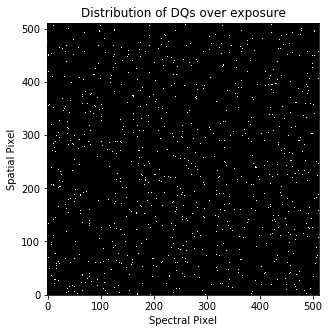

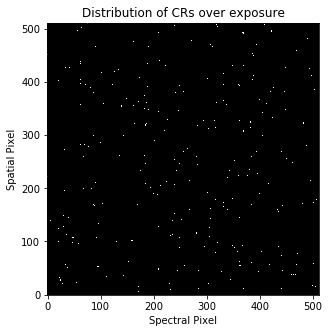

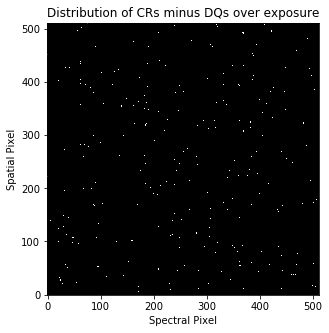

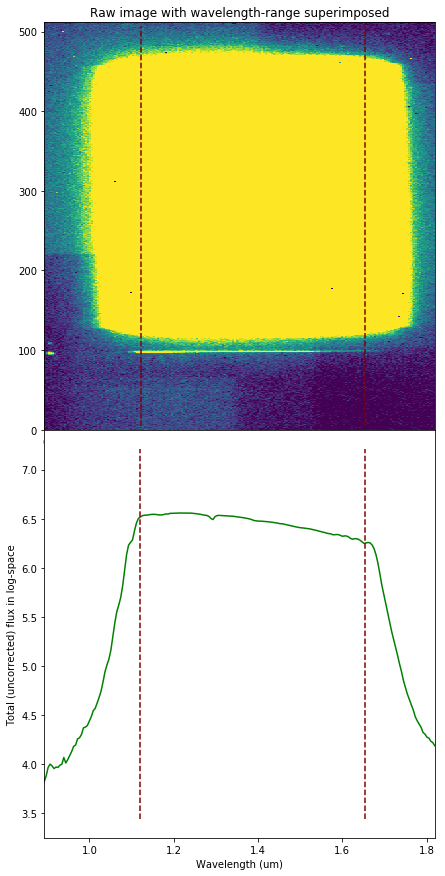

92.53801
92.53801 92.53801
Reduction took 21.41s
########################################
###########Finished Reduction###########
########################################


IOError: [Errno 2] No such file or directory: '/Users/bob/Documents/PhD/KELT-9b/output/ie3zh1uuq_red.fits'

In [14]:
reload(pipe)
reload(data.timecorr)
#fname = 'ie3zh1teq_ima.fits'
#fname = 'ie3zh1tkq_ima.fits'  #reverse
#fname = 'ie3zh1tfq_ima.fits'
fname = 'ie3zh1uuq_ima.fits'  #reference exposure
#fname = 'ie3zh1v6q_ima.fits'  #reverse#
#fname = 'ie3zh1v3q_ima.fits'  #anomalously low reverse
#fname = 'ie3zh1viq_ima.fits'  #reverse#
#fname = 'ie3zh1trq_ima.fits'  #reverse#
#fname = 'ie3zh1wwq_ima.fits'
#fname = 'ie3zh1xhq_ima.fits'
#fname = 'ie3zh1x2q_ima.fits'
#fname = 'ie3zh1weq_ima.fits'
visit = 1

if visit == 1:
    #Bg_x, Bg_y, Bg_w, Bg_h = (100, 20, 100, 100)
    Bg_x, Bg_y, Bg_w, Bg_h = (400, 5, 110, 70)
    Ref_exp = ref_Images[0].split('_ima.fits')[0]
    
if fname == Ref_exp + '_ima.fits':
    Save_sub = True
else:
    Save_sub = False

    
exp = pipe.reduce_exposure(fname, pdf=False, logger=False, debug=True,
                           skip_start=1, yguess_offset_f=-30, yguess_offset_r=60,
                           bg_x = Bg_x, bg_y = Bg_y, bg_w = Bg_w, bg_h = Bg_h,
                           tsiaras=False, cr_tolx=5, cr_toly=5, cr_thresh=70,
                           ref_exp = Ref_exp,
                           conf_file=conf_file_red, \
                           source_dir=data_dir, write = False)

if noknots:
    exp_spectrum, variance, interp_spectra, variances = \
                    pipe.extract_spectra(exp, pdf=False, logger=False, debug=True,
                    conf_file=conf_file_ext, #fit_tol=0.02, 
                    #box_h=0.88, fit_tol=0.05, order=1,
                    #box_h=0.68, fit_tol=0.05, order=1,
                    ypix_F=ypix_F, ypix_R=ypix_R,
                    save_dir=output_dir, save_sub=Save_sub, write=False)
else:
    exp_spectrum, variance, interp_spectra, variances = \
                    pipe.extract_spectra(exp, pdf=False, logger=False, debug=True,
                    conf_file=conf_file_ext, 
                    custom_knots_F=custom_knots, custom_knots_R=custom_knots[::-1], 
                    #custom_knots_F=None, custom_knots_R=None, order=1,
                    #opt_ext=False,  
                    #box_h=0.7, fit_tol=0.15,
                    ypix_F=ypix_F, ypix_R=ypix_R,
                    save_dir=output_dir, save_sub=Save_sub, show_knots=True, write=False)

# Taking multiple images...

In [15]:
Images = glob.glob(data_dir + '*_ima.fits')
Images = np.sort([image.replace(data_dir, '') for image in Images])
Images = [str(I) for I in Images]


In [16]:
Direct_images = []
with open(data_dir + 'visit_driz.lis') as g:
    for line in g:
        Direct_images.append(line.replace('\n',''))
for image in Direct_images:
    imagename = image.replace('_drz', '_ima')
    if imagename in Images:
        Images.remove(imagename)

In [17]:
Images

['ie3zh1teq_ima.fits',
 'ie3zh1tfq_ima.fits',
 'ie3zh1thq_ima.fits',
 'ie3zh1tiq_ima.fits',
 'ie3zh1tkq_ima.fits',
 'ie3zh1tlq_ima.fits',
 'ie3zh1tnq_ima.fits',
 'ie3zh1toq_ima.fits',
 'ie3zh1tqq_ima.fits',
 'ie3zh1trq_ima.fits',
 'ie3zh1ttq_ima.fits',
 'ie3zh1tuq_ima.fits',
 'ie3zh1twq_ima.fits',
 'ie3zh1txq_ima.fits',
 'ie3zh1tzq_ima.fits',
 'ie3zh1u0q_ima.fits',
 'ie3zh1u3q_ima.fits',
 'ie3zh1u5q_ima.fits',
 'ie3zh1u6q_ima.fits',
 'ie3zh1u8q_ima.fits',
 'ie3zh1u9q_ima.fits',
 'ie3zh1ubq_ima.fits',
 'ie3zh1ucq_ima.fits',
 'ie3zh1ueq_ima.fits',
 'ie3zh1ufq_ima.fits',
 'ie3zh1uhq_ima.fits',
 'ie3zh1uiq_ima.fits',
 'ie3zh1ukq_ima.fits',
 'ie3zh1ulq_ima.fits',
 'ie3zh1unq_ima.fits',
 'ie3zh1uoq_ima.fits',
 'ie3zh1uqq_ima.fits',
 'ie3zh1urq_ima.fits',
 'ie3zh1uuq_ima.fits',
 'ie3zh1uwq_ima.fits',
 'ie3zh1uxq_ima.fits',
 'ie3zh1uzq_ima.fits',
 'ie3zh1v0q_ima.fits',
 'ie3zh1v2q_ima.fits',
 'ie3zh1v3q_ima.fits',
 'ie3zh1v5q_ima.fits',
 'ie3zh1v6q_ima.fits',
 'ie3zh1v8q_ima.fits',
 'ie3zh1v9q

First do the reference exposures. They should be the first spectrum of each visit.

########################################
############Started Reduction##########
########################################
Data reduction pipeline performed on exposure /Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1uuq_ima.fits
For configuration, see pipeline conf file: /Users/bob/Documents/PhD/KELT-9b/transmission_reduction.conf
Large background of 66.2362670898 electrons per pixel found in subexposure 0
Large background of 64.6741943359 electrons per pixel found in subexposure 1
Large background of 74.1387481689 electrons per pixel found in subexposure 2
Large background of 86.6062469482 electrons per pixel found in subexposure 3
Forward scan
Catalogue used: /Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1tdq_flt_1.cat
Direct Image name: ie3zh1tdq
catalogue /Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1tdq_flt_1.cat
Catalogue file: ie3zh1tdq_flt.fits
########################
Direct image location of (249.526744058,108.06271209)
FWHM of this subexposure is  81.06801257074216


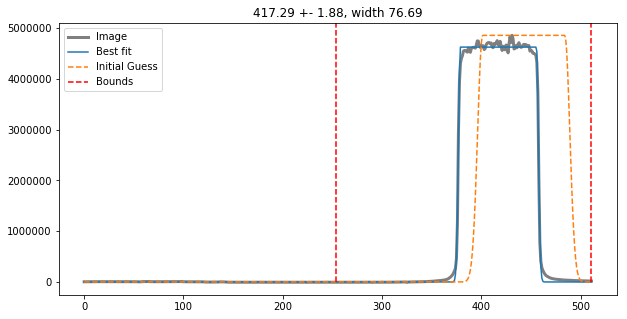

using a PHOENIX stellar model
amplitude and displacement on first order: -14.557916656910772 -2.1957350695205218


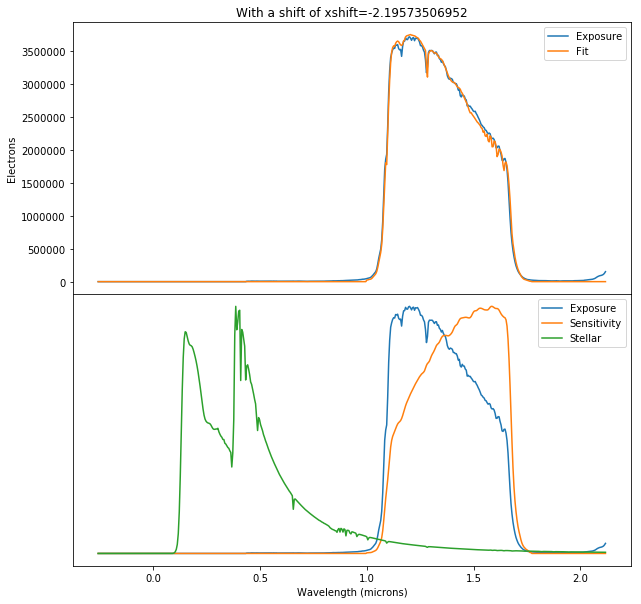

Applied an xshift of -2.19573506952 pix from a comparison to a stellar spectrum
Initial xpix is 247 and shift_in_x: -2.19573506952
-30.0 1
FWHM of this subexposure is  81.06800419769957


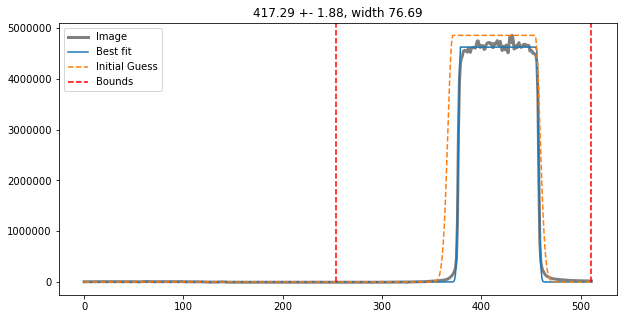

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]
-30.0 1
FWHM of this subexposure is  81.40968158795084


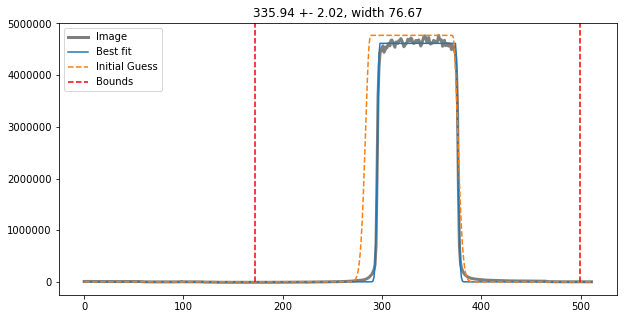

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]
-30.0 1
FWHM of this subexposure is  82.80670986608399


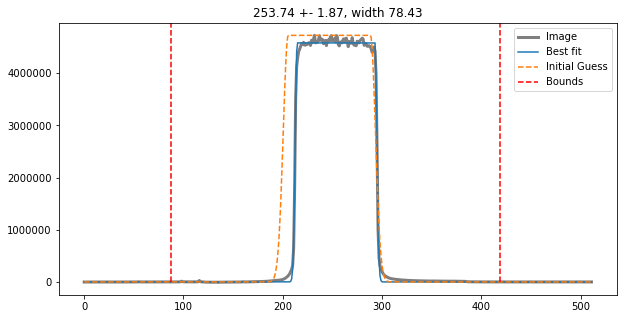

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]
-30.0 1
FWHM of this subexposure is  84.21699762316254


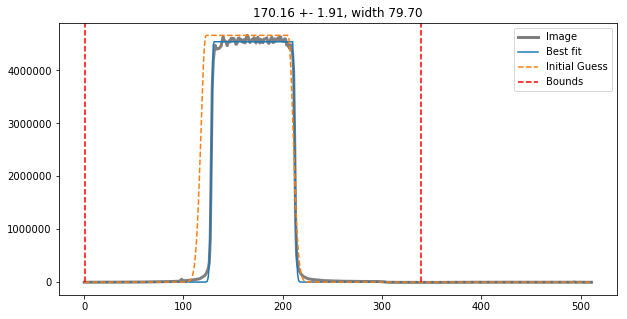

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]
The final xpix is 247
-30.0 1
FWHM of this subexposure is  81.06800419769957


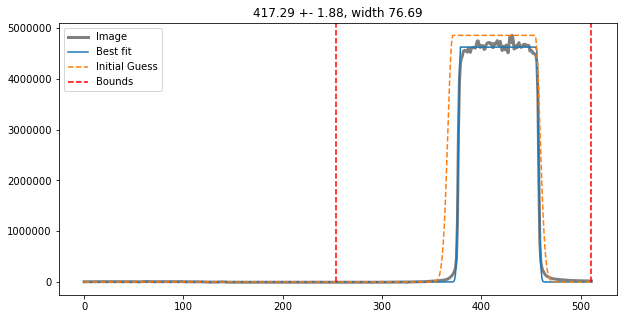

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]
-30.0 1
FWHM of this subexposure is  81.40968158795084


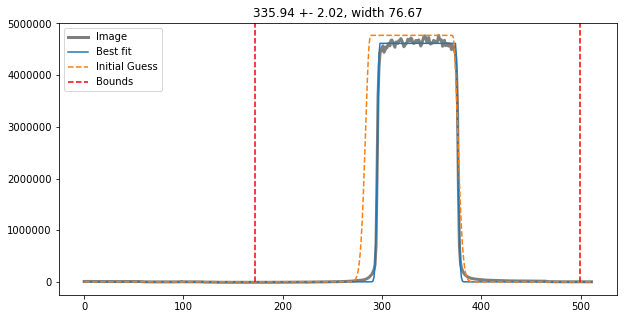

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]
-30.0 1
FWHM of this subexposure is  82.80670986608399


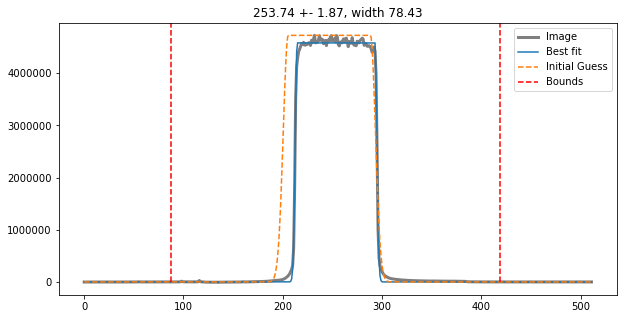

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]
-30.0 1
FWHM of this subexposure is  84.21699762316254


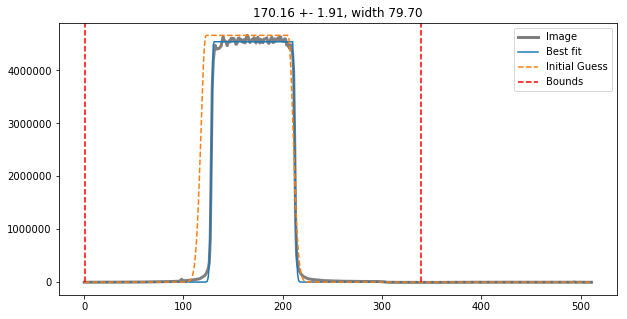

SHIFTINX -2.1957350695205218
waveschange [1.35836471 1.36302259 1.36768048 1.3723384 ]
nr_CRs, Lows 226 16
nr_CRs, Lows 215 12
nr_CRs, Lows 228 10
nr_CRs, Lows 244 7
92.53801
92.53801 92.53801
Saving reduced file to /Users/bob/Documents/PhD/KELT-9b/output/
Saving reduced exposure to /Users/bob/Documents/PhD/KELT-9b/output/ie3zh1uuq_red.fits...
Reduction took 14.25s
########################################
###########Finished Reduction###########
########################################
########################################
############Started Extraction##########
########################################
Spectral extraction pipeline performed on exposure /Users/bob/Documents/PhD/KELT-9b/HSTdata/ie3zh1uuq_ima.fits
For configuration, see conf file: /Users/bob/Documents/PhD/KELT-9b/transmission_extraction.conf
Forward scan
Extracting from subexposure 1
Extracting spectrum with a 178 high extraction box
nr. of CRs 3292
Spectrum located at pixel 347 in spatial direction
subexp 417.2921675

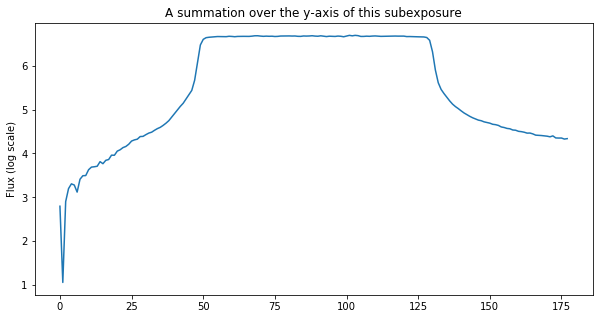

The difference between the two edges (for a 5-pixel bin for all subexps is): 2893.14140625
This value may not be larger than  7139.367516337377  or else you'll have variations induced by the moving of this subexposure on the y-axis.
Using flux for variance estimate
Extracting spectrum with optimal extraction...
Knots used are: [  0.  12.  23.  34.  43.  45.  46.  47.  48.  49.  50.  51.  52.  53.
  54.  55.  65.  75.  85.  95. 105. 115. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


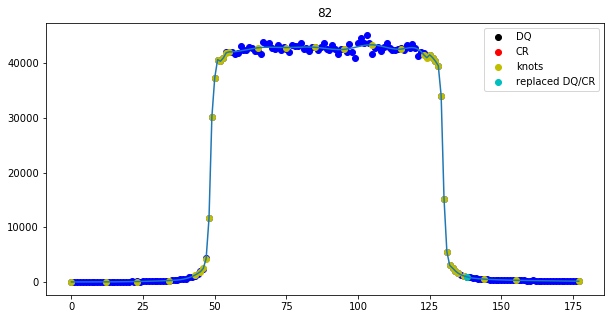

Knots used are: [  0.  12.  23.  34.  43.  45.  46.  47.  48.  49.  50.  51.  52.  53.
  54.  55.  65.  75.  85.  95. 105. 115. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


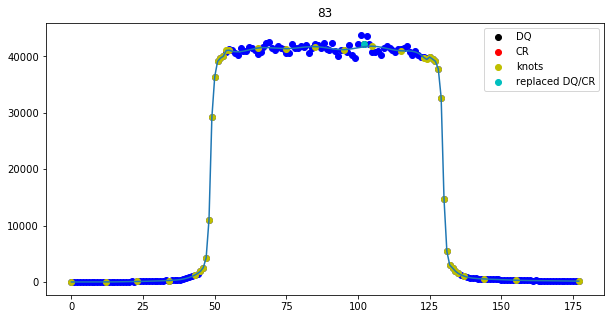

Knots used are: [  0.  12.  23.  34.  43.  45.  46.  47.  48.  49.  50.  51.  52.  53.
  54.  55.  65.  75.  85.  95. 105. 115. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


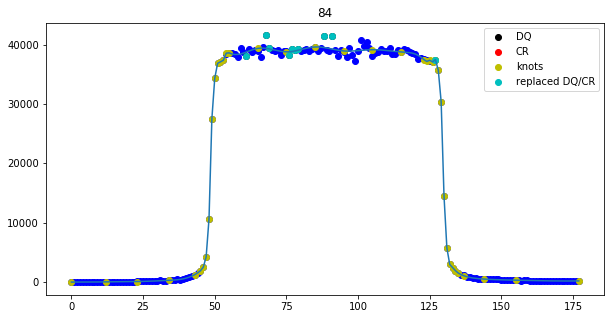

Knots used are: [  0.  12.  23.  34.  43.  45.  46.  47.  48.  49.  50.  51.  52.  53.
  54.  55.  65.  75.  85.  95. 105. 115. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


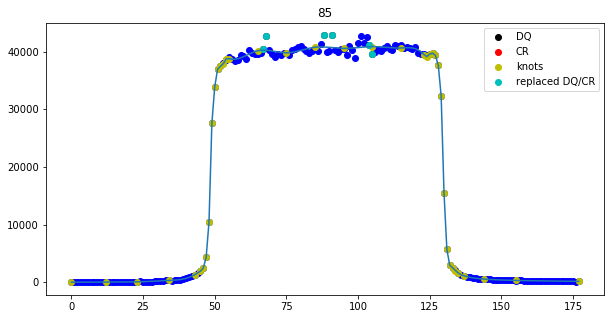

Knots used are: [  0.  12.  23.  34.  43.  45.  46.  47.  48.  49.  50.  51.  52.  53.
  54.  55.  65.  75.  85.  95. 105. 115. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


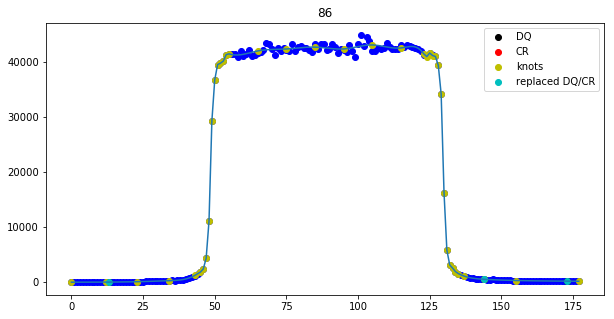

200 successes out of 200 total fits
Optimal extraction fitting failed for columns: []
Clipped 0 cosmic rays in OE
Extracting from subexposure 2
nr. of CRs 3509
Spectrum located at pixel 347 in spatial direction
subexp 335.9427245213551 [417, 336, 254, 170]
ypix is 336 for exposure 1
1 4


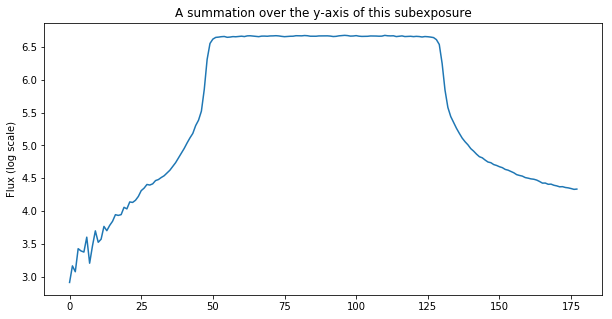

The difference between the two edges (for a 5-pixel bin for all subexps is): 2768.683072916667
This value may not be larger than  7142.815280639234  or else you'll have variations induced by the moving of this subexposure on the y-axis.
Extracting spectrum with optimal extraction...
Knots used are: [  0.  12.  23.  34.  42.  44.  45.  46.  47.  48.  49.  50.  51.  52.
  53.  54.  64.  74.  84.  94. 104. 114. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


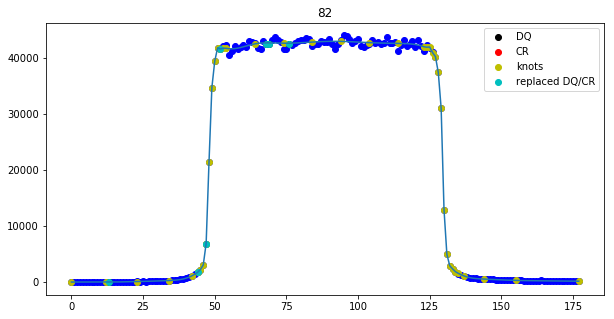

Knots used are: [  0.  12.  23.  34.  42.  44.  45.  46.  47.  48.  49.  50.  51.  52.
  53.  54.  64.  74.  84.  94. 104. 114. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


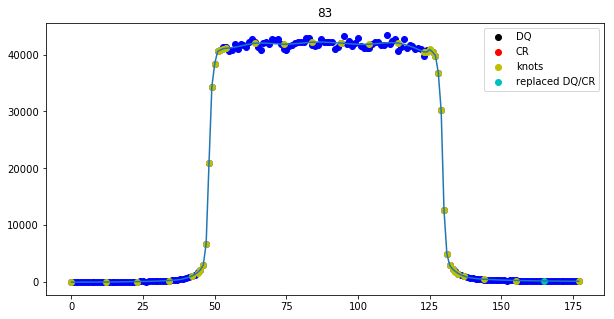

Knots used are: [  0.  12.  23.  34.  42.  44.  45.  46.  47.  48.  49.  50.  51.  52.
  53.  54.  64.  74.  84.  94. 104. 114. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


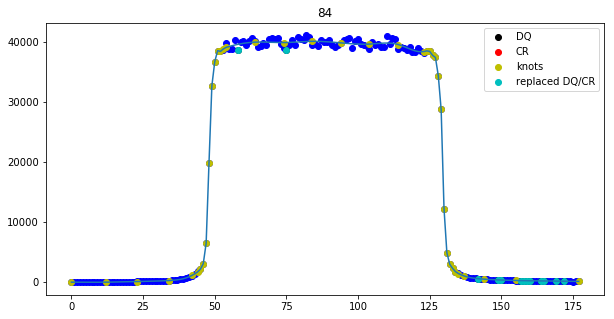

Knots used are: [  0.  12.  23.  34.  42.  44.  45.  46.  47.  48.  49.  50.  51.  52.
  53.  54.  64.  74.  84.  94. 104. 114. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


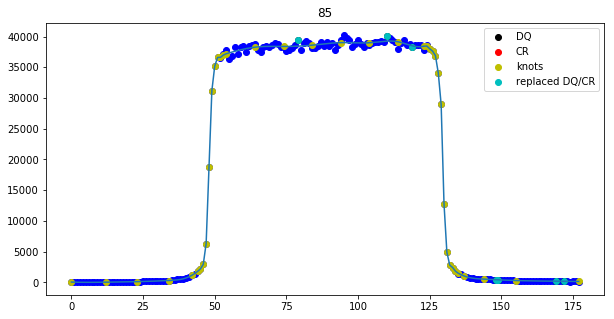

Knots used are: [  0.  12.  23.  34.  42.  44.  45.  46.  47.  48.  49.  50.  51.  52.
  53.  54.  64.  74.  84.  94. 104. 114. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


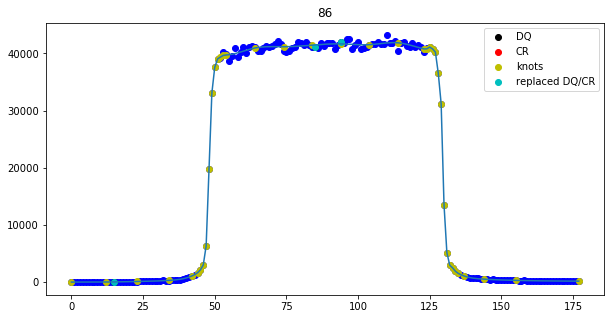

200 successes out of 200 total fits
Optimal extraction fitting failed for columns: []
Clipped 0 cosmic rays in OE
Extracting from subexposure 3
nr. of CRs 3512
Spectrum located at pixel 347 in spatial direction
subexp 253.7374561608409 [417, 336, 254, 170]
ypix is 254 for exposure 2
2 4


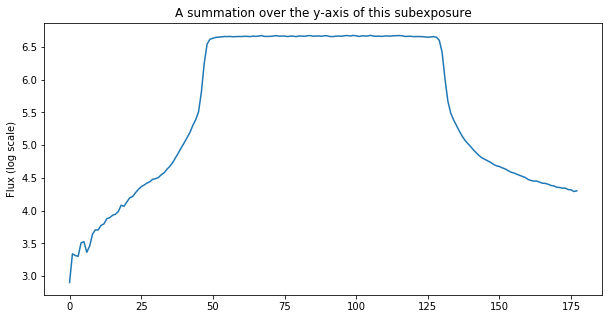

The difference between the two edges (for a 5-pixel bin for all subexps is): 2569.20703125
This value may not be larger than  7175.149410755616  or else you'll have variations induced by the moving of this subexposure on the y-axis.
Extracting spectrum with optimal extraction...
Knots used are: [  0.  12.  23.  34.  41.  43.  44.  45.  46.  47.  48.  49.  50.  51.
  52.  53.  63.  73.  83.  93. 103. 113. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


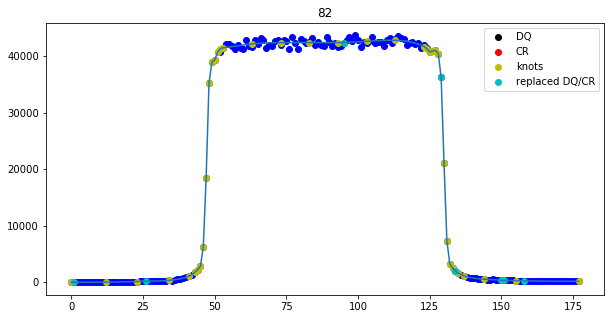

Knots used are: [  0.  12.  23.  34.  41.  43.  44.  45.  46.  47.  48.  49.  50.  51.
  52.  53.  63.  73.  83.  93. 103. 113. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


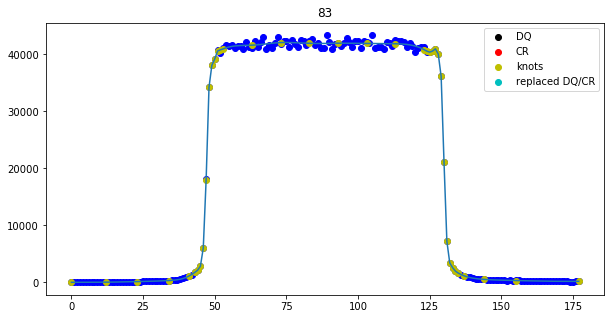

Knots used are: [  0.  12.  23.  34.  41.  43.  44.  45.  46.  47.  48.  49.  50.  51.
  52.  53.  63.  73.  83.  93. 103. 113. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


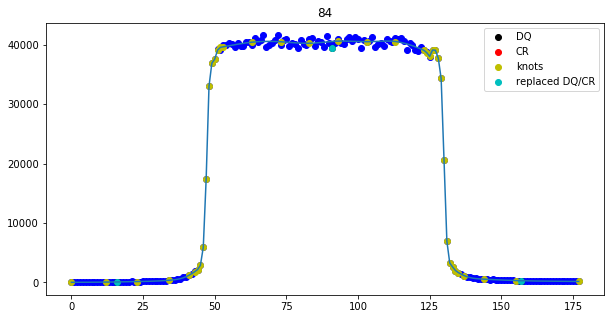

Knots used are: [  0.  12.  23.  34.  41.  43.  44.  45.  46.  47.  48.  49.  50.  51.
  52.  53.  63.  73.  83.  93. 103. 113. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


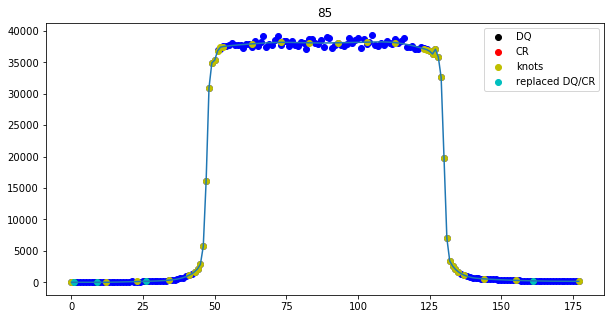

Knots used are: [  0.  12.  23.  34.  41.  43.  44.  45.  46.  47.  48.  49.  50.  51.
  52.  53.  63.  73.  83.  93. 103. 113. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


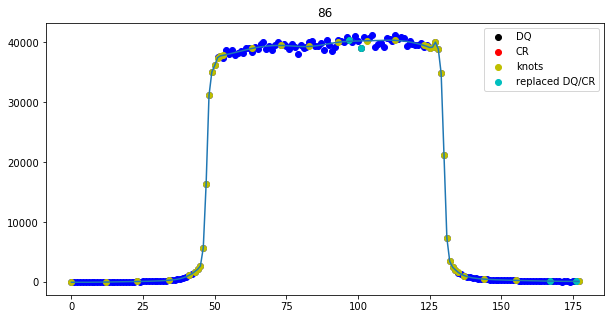

199 successes out of 200 total fits
Optimal extraction fitting failed for columns: []
Clipped 0 cosmic rays in OE
Extracting from subexposure 4
nr. of CRs 3542
Spectrum located at pixel 347 in spatial direction
subexp 170.16088847432013 [417, 336, 254, 170]
ypix is 170 for exposure 3
3 4


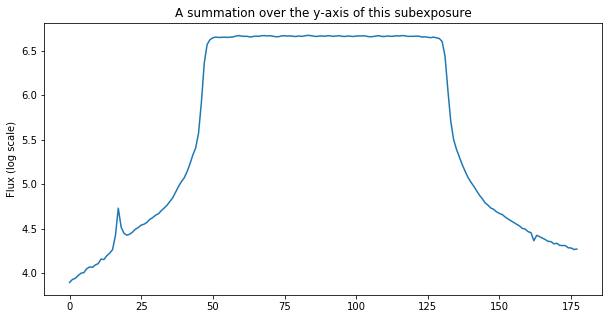

The difference between the two edges (for a 5-pixel bin for all subexps is): 1434.9040364583334
This value may not be larger than  7211.538606058119  or else you'll have variations induced by the moving of this subexposure on the y-axis.
Extracting spectrum with optimal extraction...
Knots used are: [  0.  12.  23.  34.  41.  43.  44.  45.  46.  47.  48.  49.  50.  51.
  52.  53.  63.  73.  83.  93. 103. 113. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


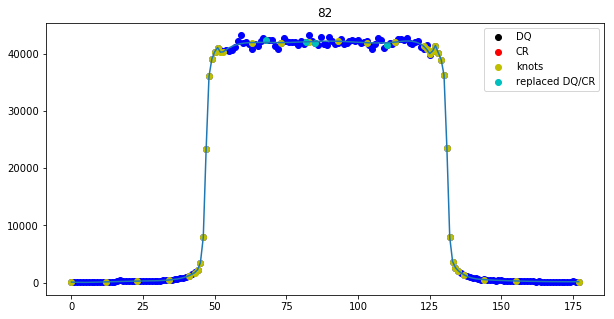

Knots used are: [  0.  12.  23.  34.  41.  43.  44.  45.  46.  47.  48.  49.  50.  51.
  52.  53.  63.  73.  83.  93. 103. 113. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


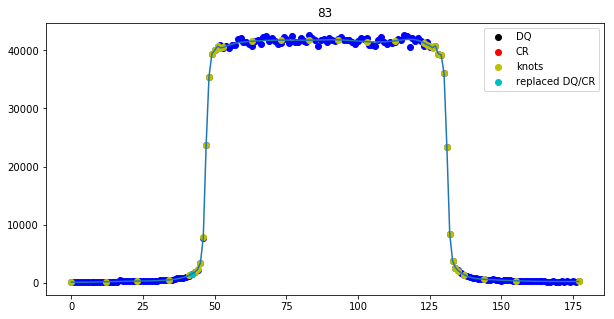

Knots used are: [  0.  12.  23.  34.  41.  43.  44.  45.  46.  47.  48.  49.  50.  51.
  52.  53.  63.  73.  83.  93. 103. 113. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


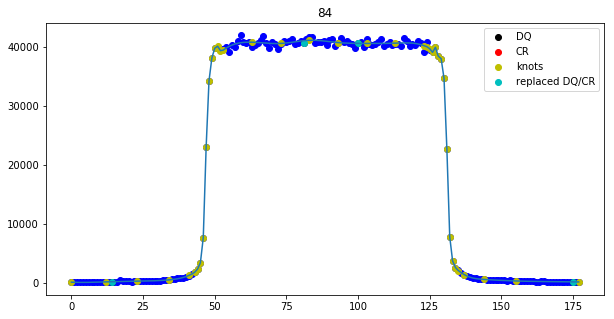

Knots used are: [  0.  12.  23.  34.  41.  43.  44.  45.  46.  47.  48.  49.  50.  51.
  52.  53.  63.  73.  83.  93. 103. 113. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


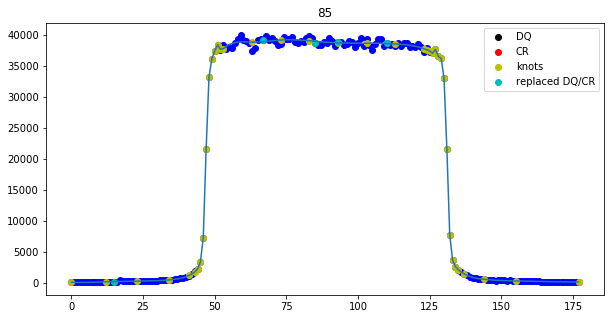

Knots used are: [  0.  12.  23.  34.  41.  43.  44.  45.  46.  47.  48.  49.  50.  51.
  52.  53.  63.  73.  83.  93. 103. 113. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 137. 144. 155. 177.]


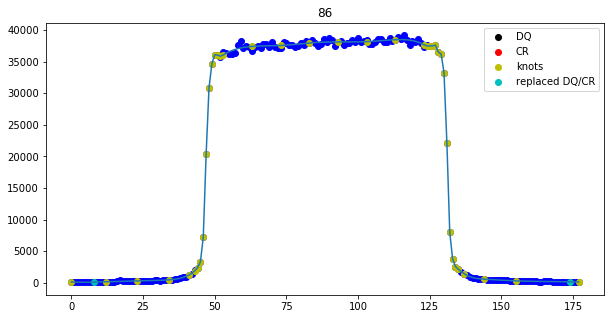

184 successes out of 200 total fits
Optimal extraction fitting failed for columns: []
Clipped 0 cosmic rays in OE
Shifted subexposure nr. 1 with -0.701292230146 pixels and shrunk 0.414695880374 percent.
Shifted subexposure nr. 2 with -1.36779981732 pixels and shrunk 0.818816537494 percent.
Shifted subexposure nr. 3 with -2.06229816661 pixels and shrunk 1.2393100004 percent.
Saving spectrum to /Users/bob/Documents/PhD/KELT-9b/output/ie3zh1uuq_spec.txt
reduced 2458873.7036050465
Saving subexposure spectra to /Users/bob/Documents/PhD/KELT-9b/output/ie3zh1uuq_subs_spec.txt
Extraction took 3.78s
########################################
###########Finished Extraction##########
########################################


In [18]:
it = 0
reload(pipe)
for Image in ref_Images:
    visit = 1
    if visit == 1:
        Bg_x, Bg_y, Bg_w, Bg_h = (400, 5, 110, 70)
        Ref_exp = ref_Images[0].split('_ima.fits')[0]
        
    if fname == Ref_exp + '_ima.fits':
        Save_sub = True
    else:
        Save_sub = True#False
        
        
    exp = pipe.reduce_exposure(Image, pdf=False, logger=False, debug=False,
                           bg_x = Bg_x, bg_y = Bg_y, bg_w = Bg_w, bg_h = Bg_h,
                           ref_exp = Ref_exp,
                           conf_file=conf_file_red, \
                           source_dir=data_dir, write = True)

    if noknots:
        exp_spectrum, variance, interp_spectra, variances = \
                    pipe.extract_spectra(exp, pdf=False, logger=False, debug=False,
                    conf_file=conf_file_ext, ref_exp=Ref_exp,
                    #box_h=0.88, fit_tol=0.05, order=1,
                    #box_h=0.68, fit_tol=0.05, order=1,
                    ypix_F=ypix_F, ypix_R=ypix_R,
                    save_dir=output_dir, save_sub=Save_sub)
    else:
        exp_spectrum, variance, interp_spectra, variances = \
                    pipe.extract_spectra(exp, pdf=False, logger=False, debug=False,
                    conf_file=conf_file_ext, ref_exp=Ref_exp, 
                    custom_knots_F=custom_knots, custom_knots_R=custom_knots[::-1], 
                    #custom_knots_F=None, custom_knots_R=None, order=1,
                    #opt_ext=False,
                    #box_h=0.37, fit_tol=0.15,
                    ypix_F=ypix_F, ypix_R=ypix_R,
                    save_dir=output_dir, save_sub=Save_sub)

In [19]:
%%capture

BGs0 = []
BGs1 = []
BGs2 = []
BGs3 = []
refshifts = []
refshifterrs = []
Ts  = []
reload(pipe)
it = 0
for Image in Images:
    visit = 1
    if visit == 1:
        Bg_x, Bg_y, Bg_w, Bg_h = (400, 5, 110, 70)
        Ref_exp = ref_Images[0].split('_ima.fits')[0]
    if Image == Ref_exp + '_ima.fits':
        Save_sub = True
    else:
        Save_sub = True#False
            
    exp = pipe.reduce_exposure(Image, pdf=False, logger=False, debug=False,
                           bg_x = Bg_x, bg_y = Bg_y, bg_w = Bg_w, bg_h = Bg_h,
                           ref_exp = Ref_exp,
                           conf_file=conf_file_red, \
                           source_dir=data_dir, write = True)

    if noknots:
        exp_spectrum, variance, interp_spectra, variances = \
                    pipe.extract_spectra(exp, pdf=False, logger=False, debug=False,
                    conf_file=conf_file_ext, ref_exp=Ref_exp,
                    #box_h=0.88, fit_tol=0.05, order=1,
                    #box_h=0.68, fit_tol=0.05, order=1,
                    ypix_F=ypix_F, ypix_R=ypix_R,
                    save_dir=output_dir, save_sub=Save_sub)
    else:
        exp_spectrum, variance, interp_spectra, variances = \
                    pipe.extract_spectra(exp, pdf=False, logger=False, debug=False,
                    conf_file=conf_file_ext, ref_exp=Ref_exp, 
                    custom_knots_F=custom_knots, custom_knots_R=custom_knots[::-1], 
                    #custom_knots_F=None, custom_knots_R=None, order=1,
                    #opt_ext=False,
                    #box_h=0.37, fit_tol=0.15,
                    ypix_F=ypix_F, ypix_R=ypix_R,
                    save_dir=output_dir, save_sub=Save_sub)
    
    BGs0.append(exp.BGs[0][0,0])
    BGs1.append(exp.BGs[1][0,0])
    BGs2.append(exp.BGs[2][0,0])
    BGs3.append(exp.BGs[3][0,0])
    refshifts.append(exp_spectrum.refshift)
    refshifterrs.append(exp_spectrum.refshifterr)
    Ts.append(exp.t)
    it +=1
    

Text(0.5,0,'Time (JD)')

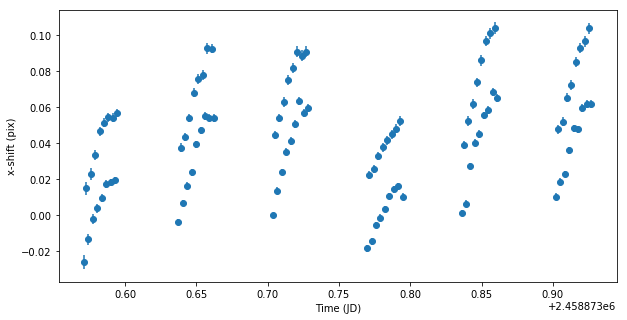

In [59]:
plt.errorbar(Ts, refshifts, yerr=refshifterrs, fmt='o')
plt.ylabel('x-shift (pix)')
plt.xlabel('Time (JD)')

Text(0,0.5,'Pixel value')

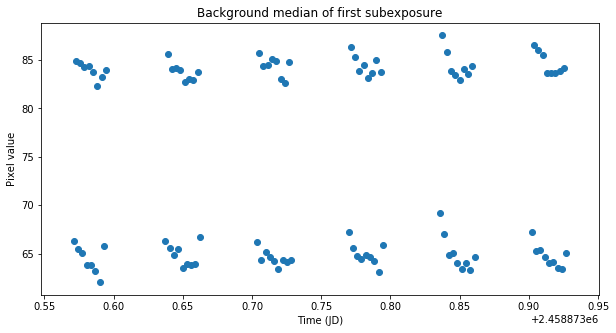

In [60]:
plt.title('Background median of first subexposure')
plt.scatter(Ts, BGs0)
plt.xlabel('Time (JD)')
plt.ylabel('Pixel value')

Text(0,0.5,'Pixel value')

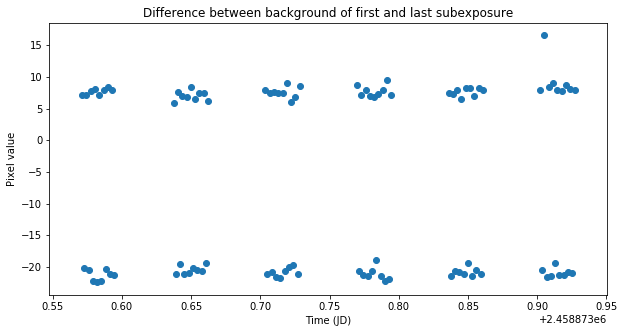

In [61]:
plt.scatter(Ts, np.array(BGs2) - np.array(BGs0))
plt.title('Difference between background of first and last subexposure')
plt.xlabel('Time (JD)')
plt.ylabel('Pixel value')

Text(0,0.5,'Pixel value')

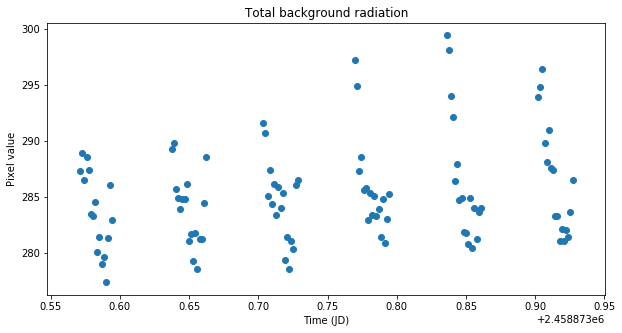

In [62]:
plt.title('Total background radiation')
plt.scatter(Ts, np.array(BGs0)+np.array(BGs1)+np.array(BGs2)+np.array(BGs3))
plt.xlabel('Time (JD)')
plt.ylabel('Pixel value')